# Superpixel learning


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = set_device(verbose=True)

cuda available


# MNIST Superpixel 

In [2]:
from superpixels import SuperPixDataset
DATASET_NAME = 'MNIST'
dataset = SuperPixDataset(DATASET_NAME)  # 54s
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset MNIST...
<_io.BufferedReader name='../Datasets/superpixels/MNIST.pkl'>
train, test, val sizes : 55000 10000 5000
[I] Finished loading.
[I] Data load time: 41.5791s


## Visualise the dataset

Label: tensor(3)
graph: DGLGraph(num_nodes=73, num_edges=584,
         ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float16)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float16)})
Largest eigenvalue: 1.3894793768835658
Smallest eigenvalue: -6.938893903907228e-17


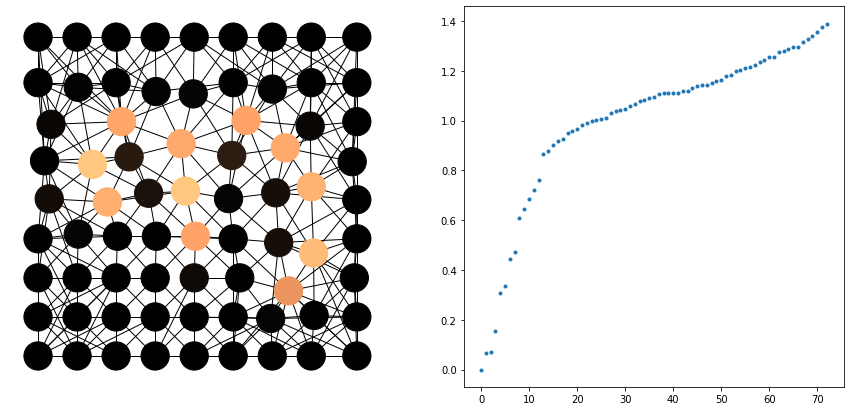

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(45000)]
nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=g_demo.ndata['feat'][:,0],
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        node_size=800,
        cmap='copper' )

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


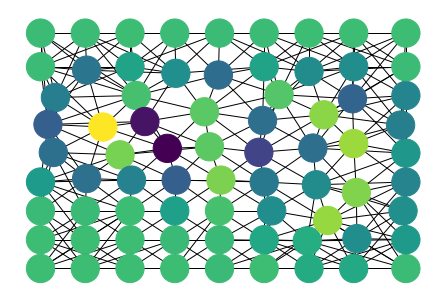

In [4]:
from utils import chebyshev
from laplacian import normalized_laplacian
L = normalized_laplacian(g_demo).to_dense()
Fmap = chebyshev(L,g_demo.ndata['feat'][:,0:3].float() ,3)

nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=Fmap[1][:,0],
        node_size=800,
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        cmap='viridis')

# Model definition for training

In [14]:
from model import DGL_mean_Classifier, DGL_global_pooling_Classifier
# model_parameters
in_features = 3
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 128
k = 4
n_classes = 10

net = DGL_mean_Classifier(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, k, readout="mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=3, out_features=64, bias=False)
        (1): Linear(in_features=3, out_features=64, bias=False)
        (2): Linear(in_features=3, out_features=64, bias=False)
        (3): Linear(in_features=3, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=False)
        (1): Linear(in_features=64, out_features=128, bias=False)
        (2): Linear(in_features=64, out_features=128, bias=False)
        (3): Linear(in_features=64, out_features=128, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=128, out_features=256, bias=False)
        (1): Linear(in_features=128, out_features=256, bias=False)
        (2): Linear(in_features=128, out_features=256, bias=False)
        (3): Linear(in_features=128, out_features=256, bias=False)
      )
  

In [15]:
from utils import load_model
net.load_state_dict(load_model('Cheb_superpix_overfit'))

<All keys matched successfully>

# Training pipe

In [16]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=128,
                         shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

, (torch.ones(2048)*1.4).to(device)

In [17]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            bGraph, label = bGraph.to(device), label.to(device)
            
            #lmax = normalized_laplacian(bGraph)
            #print(lmax)
            output = model(bGraph, 
                           bGraph.ndata.pop('feat').float().to(device), (torch.ones(2048)*1.4).to(device) )
            loss = loss_func(output, label.to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [18]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].float(), (torch.ones(1000)*1.4).to(device))
            # sum up batch loss
            test_loss += loss_func(output, label.to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f},Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [35]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

Epoch 0 loss - train 1.2476 - val 2.5484 - Acc: 30368 (55.2%) in 31.7s
Epoch 1 loss - train 1.2488 - val 2.6143 - Acc: 30278 (55.1%) in 31.2s
Epoch 2 loss - train 1.2472 - val 2.5917 - Acc: 30308 (55.1%) in 30.9s
Epoch 3 loss - train 1.2498 - val 2.7193 - Acc: 30223 (55.0%) in 30.8s
Epoch 4 loss - train 1.2578 - val 2.6403 - Acc: 30125 (54.8%) in 31.2s
Epoch 5 loss - train 1.2500 - val 2.6972 - Acc: 30231 (55.0%) in 31.1s
Epoch 6 loss - train 1.2425 - val 2.6475 - Acc: 30518 (55.5%) in 31.4s
Epoch 7 loss - train 1.2423 - val 2.6918 - Acc: 30439 (55.3%) in 30.8s
Epoch 8 loss - train 1.2494 - val 2.6899 - Acc: 30222 (54.9%) in 30.8s
Epoch 9 loss - train 1.2457 - val 2.6867 - Acc: 30431 (55.3%) in 30.8s
Epoch 10 loss - train 1.2425 - val 2.6954 - Acc: 30462 (55.4%) in 31.0s
Epoch 11 loss - train 1.2373 - val 2.7130 - Acc: 30501 (55.5%) in 31.5s
Epoch 12 loss - train 1.2319 - val 2.7018 - Acc: 30599 (55.6%) in 31.2s
Epoch 13 loss - train 1.2385 - val 2.7563 - Acc: 30455 (55.4%) in 31.0s
Ep

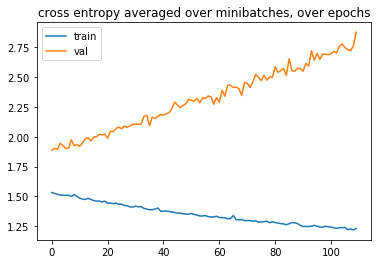

In [36]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [37]:
torch.cuda.empty_cache()

## Test Metrics

In [38]:
test(net,device,test_loader)


 Average loss per epoch: 2.9357,Accuracy: 3458/10000 (35%)

              precision    recall  f1-score   support

           0       0.47      0.50      0.48       980
           1       0.71      0.67      0.69      1135
           2       0.29      0.26      0.27      1032
           3       0.23      0.24      0.24      1010
           4       0.23      0.17      0.20       982
           5       0.22      0.22      0.22       892
           6       0.31      0.35      0.33       958
           7       0.33      0.39      0.36      1028
           8       0.29      0.32      0.31       974
           9       0.32      0.27      0.29      1009

    accuracy                           0.35     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.35      0.35      0.34     10000



## Saving

In [39]:
from utils import save_model

save_model("Cheb_superpix_overfit_mean", net)